Univariate time series data analysis is the most popular type of temporal data, where a single numeric observation is recorded sequentially over equal time periods. Only the variable observed and its relation to time is considered in this analysis.

The forecasting of future values of this univariate data is done through univariate modeling. In this case, the predictions are dependent only on historical values. The forecasting can be done through various statistical methods. 

## Moving Average Forecast

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
df = pd.read_csv('../data/GDPUS.csv', header=0)
df.head()

,Year,GDP
0,1929,821.8
1,1930,748.9
2,1931,691.3
3,1932,599.7
4,1933,587.1


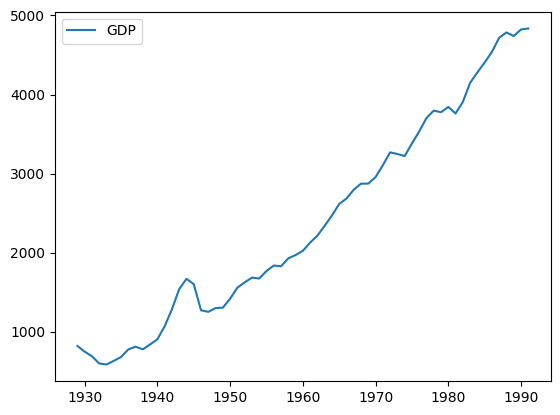

In [7]:
plt.plot(df.Year, df.GDP, label='GDP')
plt.legend(loc='best')
plt.show()

In [9]:
df_avg = df.copy()
#calculating the rolling mean - with window 5
df_avg['moving_avg_forecast'] = df['GDP'].rolling(5).mean()

In [12]:
df_avg

,Year,GDP,moving_avg_forecast
0,1929,821.8,NaN
1,1930,748.9,NaN
2,1931,691.3,NaN
3,1932,599.7,NaN
4,1933,587.1,689.76
...,...,...,...
58,1987,4718.6,4418.26
59,1988,4784.6,4545.48
60,1989,4739.2,4637.36
61,1990,4822.3,4720.92


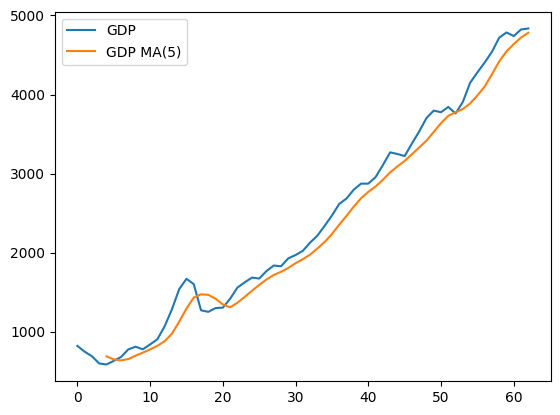

In [10]:
plt.plot(df['GDP'], label='GDP')
plt.plot(df_avg['moving_avg_forecast'], label='GDP MA(5)')
plt.legend(loc='best')
plt.show()

## Autoregressive model (AR)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf

In [19]:
df = pd.read_csv('../data/opsd_germany_daily.csv')
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


Note that the `Date` property is already in the ISO-8601 format, so we can just change the type of this column to `datetime`. Alternatively, we could have told Pandas that this column contains a date.

In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

# the alternative would have been as follows:
#df = pd.read_csv('../data/opsd_germany_daily.csv', parse_dates=[0], date_format='ISO8601')
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   Consumption  4383 non-null   float64       
 2   Wind         2920 non-null   float64       
 3   Solar        2188 non-null   float64       
 4   Wind+Solar   2187 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 171.3 KB


Text(0, 0.5, 'Consumption')

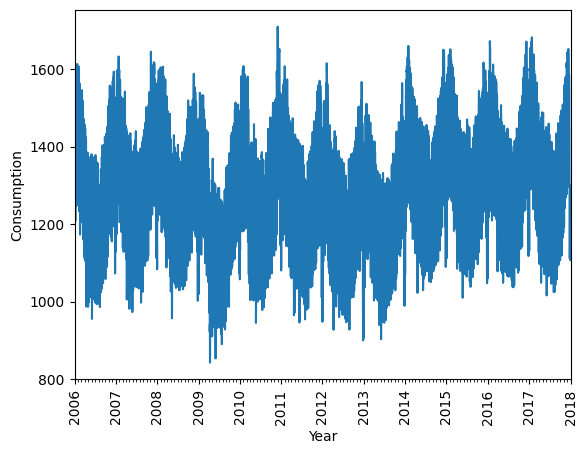

In [42]:
import matplotlib.dates as mdates
import datetime

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(df['Date'], df['Consumption'])

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.tick_params(axis='x', labelrotation=90)

datemin = datetime.date(df.Date.min().year, 1, 1)
datemax = datetime.date(df.Date.max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)
ax.set_xlabel('Year')
ax.set_ylabel('Consumption')

In [39]:
data_stationarity_test = adfuller(df['Consumption'], autolag='AIC')
print("P-value: ", data_stationarity_test[1])pacf = plot_pacf(data['Consumption'], lags=25)

P-value:  4.744054901843278e-08


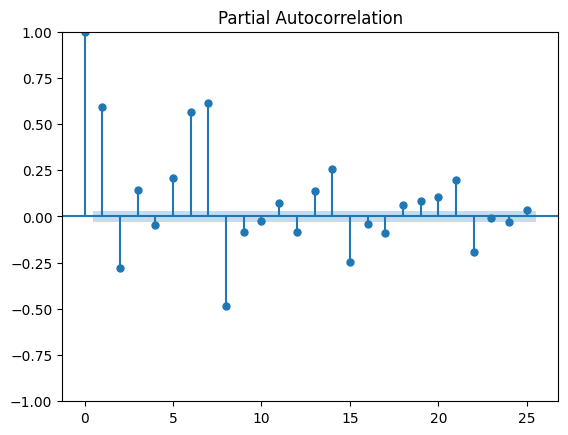

In [47]:
pacf = plot_pacf(df['Consumption'], lags=25)

Create and train a model

In [86]:
train_df = df['Consumption'][:len(df)-100]
test_df = df['Consumption'][len(df)-100:]
test_yrs = df['Date'][len(df)-100:].astype(str)

pandas.core.series.Series

In [81]:
model = AutoReg(train_df, lags=8).fit()
#model.summary()
type(test_df)

pandas.core.series.Series

In [83]:
test_df.head()

4283    1191.10345
4284    1115.07288
4285    1419.59171
4286    1445.40606
4287    1451.00792
Name: Consumption, dtype: float64

We want to make one dataframe again, with the dates, the actual and the predicted values.

In [110]:
plot_df = pd.concat([test_yrs, test_df, preds], axis=1)
plot_df.rename(columns={0:'Predicted'}, inplace=True)
plot_df['Date'] = pd.to_datetime(plot_df['Date'])
plot_df

,Date,Consumption,Predicted
4283,2017-09-23,1191.10345,1199.580761
4284,2017-09-24,1115.07288,1132.051688
4285,2017-09-25,1419.59171,1392.772651
4286,2017-09-26,1445.40606,1425.877770
4287,2017-09-27,1451.00792,1424.606502
...,...,...,...
4378,2017-12-27,1263.94091,1355.220188
4379,2017-12-28,1299.86398,1359.014426
4380,2017-12-29,1295.08753,1334.516355
4381,2017-12-30,1215.44897,1299.851112


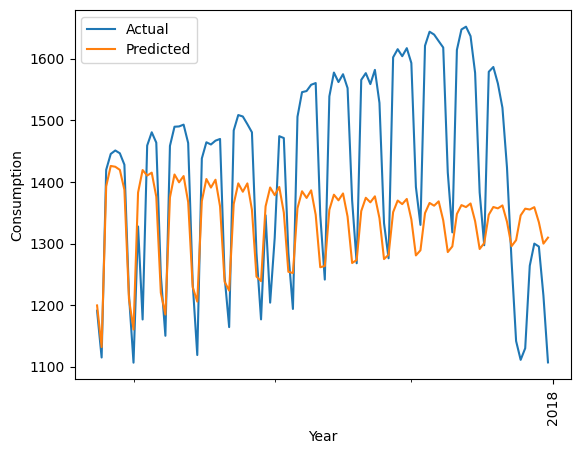

In [123]:
fig, ax = plt.subplots()

ax.plot(plot_df['Date'], plot_df['Consumption'], label='Actual')
ax.plot(plot_df['Date'], plot_df['Predicted'], label='Predicted')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.tick_params(axis='x', labelrotation=90)

# datemin = datetime.date(plot_df['Date'].min().year, 1, 1)
# datemax = datetime.date(plot_df['Date'].max().year + 1, 1, 1)
# ax.set_xlim(datemin, datemax)
ax.set_xlabel('Year')
ax.set_ylabel('Consumption')
ax.legend()